In [1]:
!pip install torch-summary

In [2]:
from google.colab import drive
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

drive.mount('./gdrive', force_remount=True)

path = '/content/gdrive/MyDrive/tobigs/'


Mounted at ./gdrive


In [3]:
train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + "sample_submission.csv")

In [4]:
# 어떤 자료인지 보자
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train_data.drop('label',axis = 1).values
y_train = train_data['label'].values

X_test = test_data.iloc[:,1:].values

In [6]:
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (18000, 784))

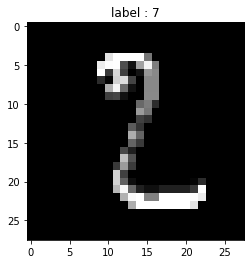

In [7]:
# 하나 출력해볼까!

index = 2
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [8]:
# 전체 784 pixel, 즉, 28*28 사이즈의 그림들임!

image_size = X_train.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


In [9]:
# scaling

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print('maximum value after scaling:', X_train.max(),
      '\nminimum value after scaling:' ,X_train.min())

maximum value after scaling: 1.0 
minimum value after scaling: 0.0


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


# gpu를 사용ㅎmport torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


# gpu
is_cuda = False
if torch.cuda.is_available() :
  is_cuda = True

# 외부 데이터를 torch으 DataLoader로 파싱하기 위해서는 tensor형의 자료가 필요하다. 
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)

# train_test split을 위하여 9 : 1로 설정해준다. 
valid_size = int(len(X_train)*0.1)
train_size = len(X_train) - valid_size

# TensorDataset으로 변환한 후 random_split을 사용하여 데이터를 split해준다.
dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test)

train_set, valid_set = torch.utils.data.dataset.random_split(dataset, [train_size, valid_size])

# TensorDataset으로 변환한 데이터를 DataLoader에 파싱을 해준다.
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=128, shuffle= True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size = 64 , shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 256, shuffle= False)






In [11]:
# batch 단위 data shape

print(f'Train set shape : {next(iter(train_loader))[0].shape} & {next(iter(train_loader))[1].shape}')
print(f'Validation set shape :  {next(iter(valid_loader))[0].shape} & {next(iter(valid_loader))[1].shape}')
print(f'Test set shape : {next(iter(test_loader))[0].shape}')

Train set shape : torch.Size([128, 784]) & torch.Size([128])
Validation set shape :  torch.Size([64, 784]) & torch.Size([64])
Test set shape : torch.Size([256, 784])


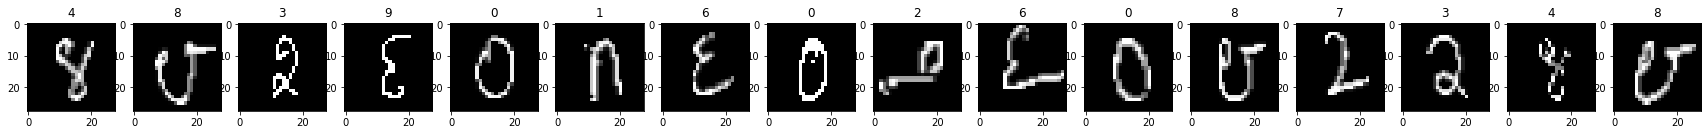

In [12]:
# 출력값을 보면 random하게 잘 된것을 확인 할 수 있다.

fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(int(batch[1][i].data.numpy().tolist()))
        image = batch[0][i].numpy()
        image *= 255.
        image = image.reshape(28,28)
        ax[i].imshow(image, cmap='gray')
    break

## DNN


In [13]:
# Pytorch의 nn.Module을 상속받아 내부 메소드들을 사용할 수 있다. 이를 통해 간단하게 3개의 층을 가진 DNN을 구성한다.
class MyModel(nn.Module) :
  def __init__(self) :
    super().__init__()
    
    self.nn1 = nn.Linear(784, 256)
    self.nn2 = nn.Linear(256, 128)
    self.nn3 = nn.Linear(128, 64)
    self.nn4 = nn.Linear(64,10)


  def forward(self, x) :
    x = F.relu(self.nn1(x))
    x = F.relu(self.nn2(x))
    x = F.relu(self.nn3(x))
    x = self.nn4(x)
    return F.log_softmax(x, dim = 1) # 이 경우 log_softmax로 output을 출력하였기 때문에 nll_loss를 이용하여 loss를 계산한다. 만약 x만 return 했을 경우 CrossEntropyLoss 를 loss function으로 설정하여 학습을 진행하면 된다.

In [14]:
model = MyModel().cuda()
print(model)

MyModel(
  (nn1): Linear(in_features=784, out_features=256, bias=True)
  (nn2): Linear(in_features=256, out_features=128, bias=True)
  (nn3): Linear(in_features=128, out_features=64, bias=True)
  (nn4): Linear(in_features=64, out_features=10, bias=True)
)


In [15]:
from torchsummary import summary
 
summary(model, input_size = tuple([784,]), verbose = 0) # model의 구조를 확인해 보면 다음과 같다.

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            200,960
├─Linear: 1-2                            32,896
├─Linear: 1-3                            8,256
├─Linear: 1-4                            650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0

In [206]:
# 학습에 필요한 함수를 정의 해준다. training, validation에 대하여 각각 loss와 accuracy를 구해야 하기 때문에 분리하여 진행한다.
def fit(epoch, model, data_loader , phase = 'training',volatile = False) : 
  if phase == 'training':  
    model.train()
  if phase == 'validation' : 
    model.eval()
    volatile = True  # 여기서 volatile은 휘발성 데이터를 설정하는 방법으로 validation은 별도로 autograd를 할 필요 없기 때문에 Variable로 변환할 때 인자를 주어 validation 학습시 영향을 주는것을 방지한다.
  
  running_loss = 0.0
  running_correct = 0

  for batch_idx , (data,target) in enumerate(data_loader) :
    if is_cuda :
      data, target = data.cuda(), target.cuda()  # gpu를 이용하여 학습
    
    data, target = Variable(data, volatile), Variable(target) # autograd를 사용하기 위해 Variable 타입으로 변환해 주지만 현재는 tensor타입과 병합되어 default로 autograd를 지원한다고 한다.

    if phase == 'training' :
      optimizer.zero_grad() 
    
    output = model(data)  
    loss = F.nll_loss(output, target) 

    running_loss += F.nll_loss(output,target,size_average=False).item() 
    preds = output.data.max(dim=1,keepdim=True)[1] 
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() 
    if phase == 'training':
      loss.backward()  
      optimizer.step()
    loss = running_loss/len(data_loader.dataset) 
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
  print(f'{phase} {epoch} Loss : {loss:{5}.{4}} \t Accuracy : {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}%')
  return loss, accuracy

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001) # optimizer : Adam , learning rate : 0.001
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 100) :
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_loader, phase = 'validation') 

  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training 1 Loss : 0.3341 	 Accuracy : 34315/37800     90.78%
validation 1 Loss : 0.1208 	 Accuracy : 4053/4200      96.5%
training 2 Loss : 0.09668 	 Accuracy : 36724/37800     97.15%
validation 2 Loss : 0.1043 	 Accuracy : 4077/4200     97.07%
training 3 Loss : 0.06515 	 Accuracy : 37052/37800     98.02%
validation 3 Loss : 0.08449 	 Accuracy : 4099/4200      97.6%
training 4 Loss : 0.04806 	 Accuracy : 37263/37800     98.58%
validation 4 Loss : 0.07859 	 Accuracy : 4101/4200     97.64%
training 5 Loss : 0.03463 	 Accuracy : 37410/37800     98.97%
validation 5 Loss : 0.06345 	 Accuracy : 4126/4200     98.24%
training 6 Loss : 0.02512 	 Accuracy : 37497/37800      99.2%
validation 6 Loss : 0.08143 	 Accuracy : 4112/4200      97.9%
training 7 Loss : 0.02009 	 Accuracy : 37561/37800     99.37%
validation 7 Loss : 0.07952 	 Accuracy : 4098/4200     97.57%
training 8 Loss : 0.01417 	 Accuracy : 37647/37800      99.6%
validation 8 Loss : 0.08273 	 Accuracy : 4110/4200     97.86%
training 9 

<function matplotlib.pyplot.show>

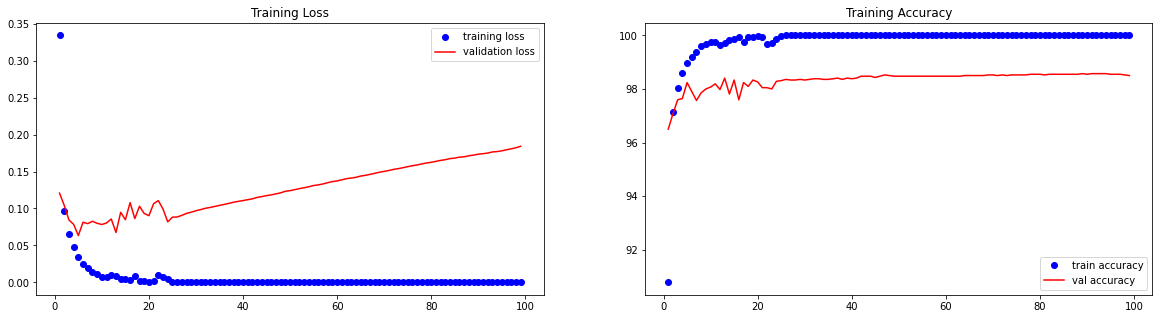

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Training Accuracy')
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



plt.show()

- Loss를 확인해 보면 20번 이후로 상당한 overfitting이 나타남을 볼수 있다. 따라서 epochs를 20으로 두고 다시 학습을 진행한다.

In [ ]:
model = MyModel().cuda()
print(model)


optimizer = optim.Adam(model.parameters(),lr=0.001)
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 20) :
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_loader, phase = 'validation') 

  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

MyModel(
  (nn1): Linear(in_features=784, out_features=256, bias=True)
  (nn2): Linear(in_features=256, out_features=128, bias=True)
  (nn3): Linear(in_features=128, out_features=64, bias=True)
  (nn4): Linear(in_features=64, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training 1 Loss : 0.331 	 Accuracy : 34109/37800     90.24%
validation 1 Loss : 0.1192 	 Accuracy : 4053/4200      96.5%
training 2 Loss : 0.09323 	 Accuracy : 36791/37800     97.33%
validation 2 Loss : 0.1231 	 Accuracy : 4033/4200     96.02%
training 3 Loss : 0.06553 	 Accuracy : 37054/37800     98.03%
validation 3 Loss : 0.07882 	 Accuracy : 4098/4200     97.57%
training 4 Loss : 0.04749 	 Accuracy : 37258/37800     98.57%
validation 4 Loss : 0.066 	 Accuracy : 4126/4200     98.24%
training 5 Loss : 0.03276 	 Accuracy : 37429/37800     99.02%
validation 5 Loss : 0.06877 	 Accuracy : 4119/4200     98.07%
training 6 Loss : 0.02334 	 Accuracy : 37541/37800     99.31%
validation 6 Loss : 0.07412 	 Accuracy : 4124/4200     98.19%
training 7 Loss : 0.01875 	 Accuracy : 37584/37800     99.43%
validation 7 Loss : 0.06782 	 Accuracy : 4126/4200     98.24%
training 8 Loss : 0.01422 	 Accuracy : 37639/37800     99.57%
validation 8 Loss : 0.07373 	 Accuracy : 4123/4200     98.17%
training 9 Los

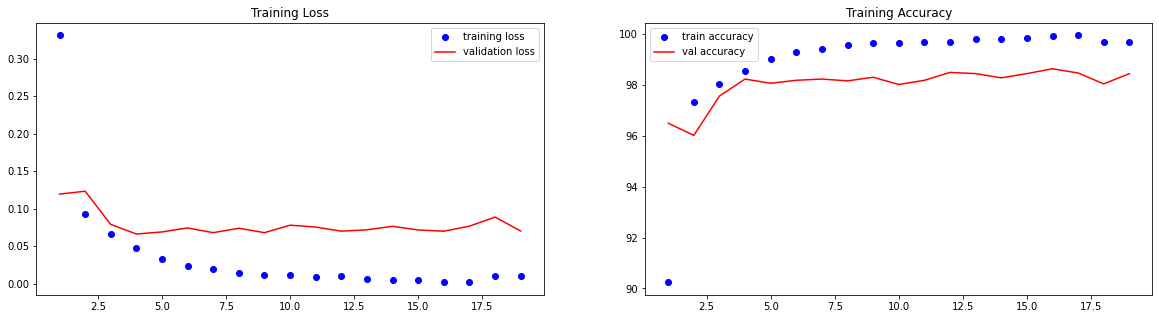

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Training Accuracy')
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



plt.show()

- 이전 결과보다 loss가 튀는 현상은 막았지만 validation loss에 비해 training loss가 현저히 낮게 보인다

In [ ]:
test_results = []
with torch.no_grad() :
  for data in test_loader :
    data = data[0].cuda()
    outputs = model(data)
    _, preds = torch.max(outputs.data, 1)
    
    test_results += preds.tolist()


In [ ]:
sample_submission['Category'] = test_results

In [ ]:
sample_submission.to_csv("submission_dnn.csv",index=False)

## DNN : add BatchNorm

In [17]:
class MyModel2(nn.Module) :
  def __init__(self) :
    super(MyModel2, self).__init__()
    
    self.nn1 = nn.Linear(784, 256)
    self.nn2 = nn.Linear(256, 128)
    self.nn3 = nn.Linear(128, 64)
    self.nn4 = nn.Linear(64,10)

    self.bn1 = nn.BatchNorm1d(256)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(64)



  def forward(self, x) :
    x = F.relu(self.bn1(self.nn1(x)))
    x = F.relu(self.bn2(self.nn2(x)))
    x = F.relu(self.bn3(self.nn3(x)))
    x = self.nn4(x)
    return F.log_softmax(x, dim = 1)

In [18]:
model = MyModel2().cuda()

In [19]:
from torchsummary import summary
 
summary(model, input_size = tuple([784,]), verbose = 0)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            200,960
├─Linear: 1-2                            32,896
├─Linear: 1-3                            8,256
├─Linear: 1-4                            650
├─BatchNorm1d: 1-5                       512
├─BatchNorm1d: 1-6                       256
├─BatchNorm1d: 1-7                       128
Total params: 243,658
Trainable params: 243,658
Non-trainable params: 0

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 30) :
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_loader, phase = 'validation') 

  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training 1 Loss : 0.2558 	 Accuracy : 35965/37800     95.15%
validation 1 Loss : 0.07737 	 Accuracy : 4116/4200      98.0%
training 2 Loss : 0.06041 	 Accuracy : 37167/37800     98.33%
validation 2 Loss : 0.06272 	 Accuracy : 4127/4200     98.26%
training 3 Loss : 0.03438 	 Accuracy : 37449/37800     99.07%
validation 3 Loss : 0.05058 	 Accuracy : 4139/4200     98.55%
training 4 Loss : 0.02384 	 Accuracy : 37525/37800     99.27%
validation 4 Loss : 0.05167 	 Accuracy : 4134/4200     98.43%
training 5 Loss : 0.01692 	 Accuracy : 37610/37800      99.5%
validation 5 Loss : 0.051 	 Accuracy : 4139/4200     98.55%
training 6 Loss : 0.01527 	 Accuracy : 37625/37800     99.54%
validation 6 Loss : 0.04822 	 Accuracy : 4152/4200     98.86%
training 7 Loss : 0.01181 	 Accuracy : 37672/37800     99.66%
validation 7 Loss : 0.05846 	 Accuracy : 4131/4200     98.36%
training 8 Loss : 0.01024 	 Accuracy : 37679/37800     99.68%
validation 8 Loss : 0.04962 	 Accuracy : 4156/4200     98.95%
training 9 

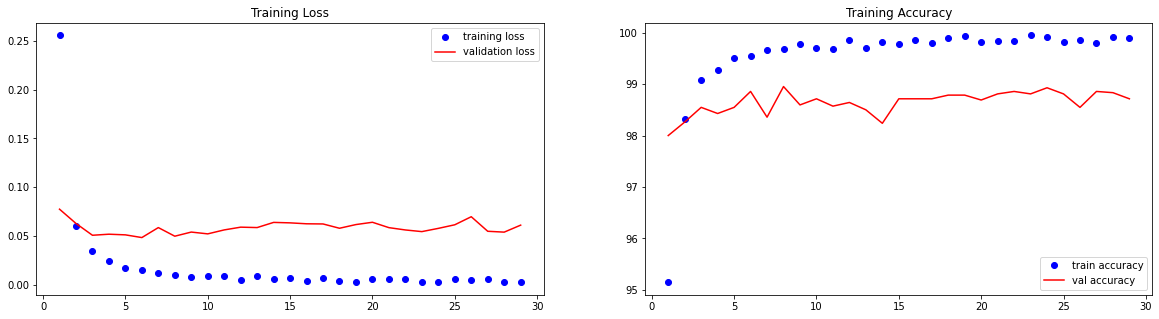

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Training Accuracy')
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



plt.show()

- BatchNormalization을 추가한 결과 이전 보다 학습이 더욱 안정적으로 되는것을 확인 할 수 있다.

In [ ]:
test_results = []
with torch.no_grad() :
  for data in test_loader :
    data = data[0].cuda()
    outputs = model(data)
    _, preds = torch.max(outputs.data, 1)
    
    test_results += preds.tolist()


In [ ]:
sample_submission['Category'] = test_results

In [ ]:
sample_submission.to_csv("submission_dnn_batch.csv",index=False)

## CNN

In [20]:
train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + "sample_submission.csv")

X_train = train_data.drop('label',axis = 1).values
y_train = train_data['label'].values

X_test = test_data.iloc[:,1:].values

X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (18000, 784))

In [21]:
X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.

#y_train = y_train.reshape(y_train.shape[0],1)

In [22]:
# CNN은 이미지 처리에 가장 특화되어있는 딥러닝 알고리즘이다. 이미지의 형태는 (channels, height, width) or (height, width, channels) 인데, pytorch의 경우 channel-first과 tensorflow의 경우 channel-last이다. (둘다 지원되기는 한다.)
# 따라서 이미지로 변환하기 위해 (1,28,28) 형태로 바꾸어야 하는데 여기서 torch.utils.data.Dataset을 이용하여 간편하게 TensorDataset을 만들 수 있다.

class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data , label = None, transform=None):
        self.data = data
        self.label = label
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index].reshape([28, 28,1])

        if self.transform:
            x = self.transform(x)

        if self.label is not None:
          y = self.label[index]
          return x, y
        else :
          return x
        

    def __len__(self):
        return len(self.data)

In [186]:
is_cuda = False
if torch.cuda.is_available() :
  is_cuda = True

torch.utils.data.datas
# CustomerDataset을 이용하면 transforms 함수들을 사용할 수 있는데 이는 이미지 처리에 유용하다.

trans = transforms.Compose([
                            transforms.ToTensor()])
train_dataset = CustomTensorDataset(data=X_train,label = y_train, transform=trans)
test_dataset = CustomTensorDataset(data=X_test,transform=trans)

valid_size = int(len(X_train)*0.1)
train_size = len(X_train) - valid_size

train_set, valid_set = torch.utils.data.dataset.random_split(train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=256, shuffle= True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size = 128 , shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 256, shuffle= False)

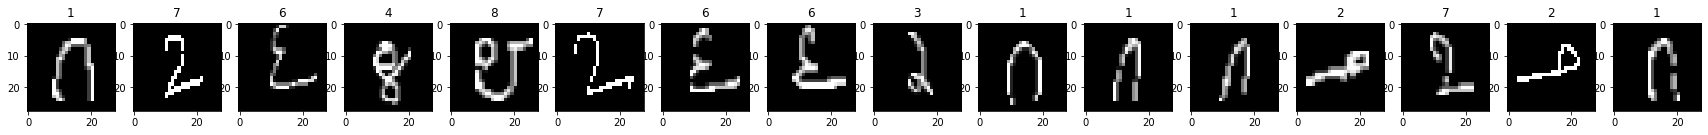

In [187]:
# 이미지 결과 확인
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(int(batch[1][i].data.numpy().tolist()))
        ax[i].imshow(batch[0][i, 0], cmap='gray')
    break

In [188]:
# shape을 확인해보면 (1,28,28)임을 확인할 수 있다.

print(f'Train set shape : {next(iter(train_loader))[0].shape} & {next(iter(train_loader))[1].shape}')
print(f'Validation set shape :  {next(iter(valid_loader))[0].shape} & {next(iter(valid_loader))[1].shape}')
print(f'Test set shape : {next(iter(test_loader)).shape}')

Train set shape : torch.Size([256, 1, 28, 28]) & torch.Size([256])
Validation set shape :  torch.Size([128, 1, 28, 28]) & torch.Size([128])
Test set shape : torch.Size([256, 1, 28, 28])


In [ ]:
class MyCnn(nn.Module):  
  def __init__(self):  
    super(MyCnn,self).__init__()  
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
    self.conv2_drop = nn.Dropout2d(p=0.1) 
    self.fc1 = nn.Linear(320, 50) 
    self.fc2 = nn.Linear(50, 10) 

  def forward(self, x): 
    x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = self.fc2(x) 
    return F.log_softmax(x,dim=1) 

model = MyCnn().cuda()
print(model)
 

MyCnn(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.1, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
import torchsummary
 
torchsummary.summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 24, 24]          260
├─Conv2d: 1-2                            [-1, 20, 8, 8]            5,020
├─Dropout2d: 1-3                         [-1, 20, 8, 8]            --
├─Linear: 1-4                            [-1, 50]                  16,050
├─Linear: 1-5                            [-1, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 24, 24]          260
├─Conv2d: 1-2                            [-1, 20, 8, 8]            5,020
├─Dropout2d: 1-3                         [-1, 20, 8, 8]            --
├─Linear: 1-4                            [-1, 50]                  16,050
├─Linear: 1-5                            [-1, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

for epoch in range(1, 20) :
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_loader, phase = 'validation') 

  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training 1 Loss : 0.4371 	 Accuracy : 32898/37800     87.03%
validation 1 Loss : 0.1451 	 Accuracy : 4021/4200     95.74%
training 2 Loss : 0.1067 	 Accuracy : 36580/37800     96.77%
validation 2 Loss : 0.08939 	 Accuracy : 4086/4200     97.29%
training 3 Loss : 0.07283 	 Accuracy : 36968/37800      97.8%
validation 3 Loss : 0.07299 	 Accuracy : 4114/4200     97.95%
training 4 Loss : 0.05736 	 Accuracy : 37170/37800     98.33%
validation 4 Loss : 0.05638 	 Accuracy : 4128/4200     98.29%
training 5 Loss : 0.04728 	 Accuracy : 37258/37800     98.57%
validation 5 Loss : 0.04995 	 Accuracy : 4139/4200     98.55%
training 6 Loss : 0.03958 	 Accuracy : 37360/37800     98.84%
validation 6 Loss : 0.04638 	 Accuracy : 4140/4200     98.57%
training 7 Loss : 0.03513 	 Accuracy : 37380/37800     98.89%
validation 7 Loss : 0.04803 	 Accuracy : 4144/4200     98.67%
training 8 Loss : 0.02981 	 Accuracy : 37464/37800     99.11%
validation 8 Loss : 0.04427 	 Accuracy : 4148/4200     98.76%
training 9 

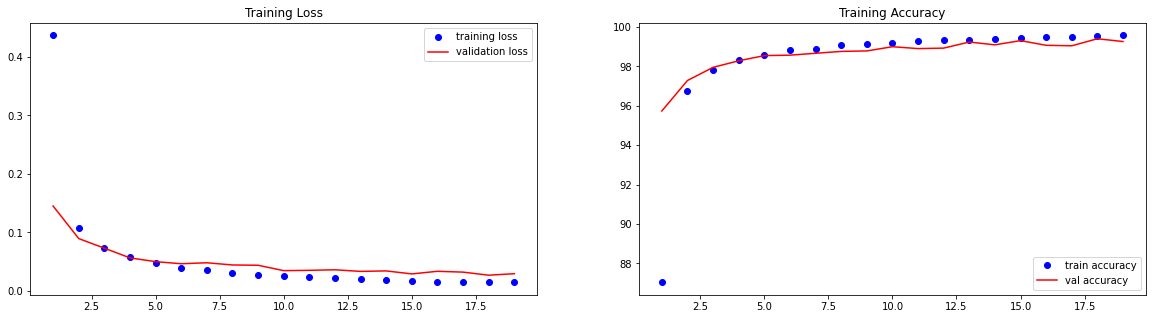

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Training Accuracy')
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



plt.show()

- 간단한 cnn모델을 통하여 학습을 시킨후 결과를 보면 DNN보다 안정된 학습을 보임을 확인할 수 있다.

In [ ]:
test_results = []
with torch.no_grad() :
  for data in test_loader :
    data = data.cuda()
    outputs = model(data)
    _, preds = torch.max(outputs.data, 1)
    
    test_results += preds.tolist()

In [ ]:
sample_submission['Category'] = test_results

sample_submission.to_csv("submission_cnn.csv",index=False)

## CNN -VGG11

- CNN을 이용한 유명한 모델들이 존재하는데 이 중 VGG11을 구현하여 데이터에 학습을 시켜 보겠다.

In [ ]:
def conv(in_channels, out_channels):
  return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,bias=False)

class Block(nn.Sequential):
  def __init__(self, in_channels, out_channels, stack, add_maxpool = False ,act=nn.ReLU(True)):
    m = [conv(in_channels, out_channels), nn.BatchNorm2d(out_channels), act]
    for _ in range(stack-1):
      m.append(conv(out_channels, out_channels))
      m.append(nn.BatchNorm2d(out_channels))
      m.append(act)
    if add_maxpool :  # 추가해준 이유는 28x28 -> 14x14 -> 7x7 -> 3x3 -> 1x1 -> 0x0 이 되기 때문에 padding을 추가하여 28x28 -> 14x14 -> 8x8 -> 4x4 -> 2x2 -> 1x1 이 되게함
      m.append(nn.MaxPool2d(2,2,padding=1))
    else :
      m.append(nn.MaxPool2d(2,2))
    
    super(Block, self).__init__(*m)  


class Vgg11(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = Block(1, 64, 1) 
    self.conv2 = Block(64, 128, 1)
    self.conv3 = Block(128, 256, 2, True)
    self.conv4 = Block(256, 512, 2)
    self.conv5 = Block(512, 512, 2)
    
    self.fc = nn.Sequential(nn.Linear(512, 4096),
                             nn.ReLU(True),
                             nn.Dropout(),
                             nn.Linear(4096, 1000),
                             nn.ReLU(True),
                             nn.Dropout(),
                             nn.Linear(1000, 10))


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = torch.flatten(x,1)
    x = self.fc(x)
    return F.log_softmax(x,dim=1)

model = Vgg11().cuda()
print(model)

Vgg11(
  (conv1): Block(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Block(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Block(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

In [ ]:
torchsummary.summary(model, (1,28,28),verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Block: 1-1                             [-1, 64, 14, 14]          --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          576
|    └─BatchNorm2d: 2-2                  [-1, 64, 28, 28]          128
|    └─ReLU: 2-3                         [-1, 64, 28, 28]          --
├─Block: 1                               []                        --
|    └─ReLU: 2-4                         [-1, 64, 28, 28]          --
├─Block: 1                               []                        --
|    └─ReLU: 2-5                         [-1, 64, 28, 28]          --
├─Block: 1                               []                        --
|    └─ReLU: 2-6                         [-1, 64, 28, 28]          --
├─Block: 1                               []                        --
|    └─ReLU: 2-7                         [-1, 64, 28, 28]          --
├─Block: 1                               []                        --
|    └─MaxPoo

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

for epoch in range(1, 15) :
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_loader, phase = 'validation') 

  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training 1 Loss : 0.8511 	 Accuracy : 24496/37800      64.8%
validation 1 Loss : 0.256 	 Accuracy : 3927/4200      93.5%
training 2 Loss : 0.08528 	 Accuracy : 36986/37800     97.85%
validation 2 Loss : 0.2821 	 Accuracy : 3899/4200     92.83%
training 3 Loss : 0.05177 	 Accuracy : 37322/37800     98.74%
validation 3 Loss : 0.05796 	 Accuracy : 4142/4200     98.62%
training 4 Loss : 0.03982 	 Accuracy : 37439/37800     99.04%
validation 4 Loss : 0.03997 	 Accuracy : 4163/4200     99.12%
training 5 Loss : 0.03809 	 Accuracy : 37443/37800     99.06%
validation 5 Loss : 0.05536 	 Accuracy : 4145/4200     98.69%
training 6 Loss : 0.03027 	 Accuracy : 37537/37800      99.3%
validation 6 Loss : 0.03719 	 Accuracy : 4160/4200     99.05%
training 7 Loss : 0.02766 	 Accuracy : 37555/37800     99.35%
validation 7 Loss : 0.05336 	 Accuracy : 4156/4200     98.95%
training 8 Loss : 0.02273 	 Accuracy : 37613/37800     99.51%
validation 8 Loss : 0.0242 	 Accuracy : 4173/4200     99.36%
training 9 Lo

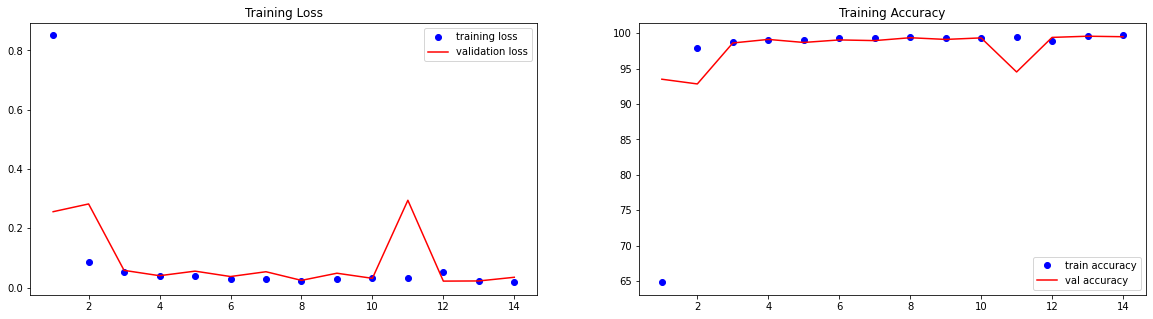

In [ ]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Training Accuracy')
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



plt.show()

- 결과를 확인해보면 loss가 한번씩 튀는 경향이 있지만 어느정도 성능이 나옴을 확인 할 수 있다.

In [ ]:
test_results = []
with torch.no_grad() :
  for data in test_loader :
    data = data.cuda()
    outputs = model(data)
    _, preds = torch.max(outputs.data, 1)
    
    test_results += preds.tolist()

In [ ]:
sample_submission['Category'] = test_results

sample_submission.to_csv("submission_cnn_vgg.csv",index=False)

## CNN - ResNet18

- ResNet 또한 VGG와 같은 CNN 모델인데 VGG보다 성능이 뛰어나다. 특히 skip connection이라는 개념을 도입시켜 성능을 올렸다. 

In [244]:
def conv(in_channels, out_channels, kernel_size = 3,stride = 1,padding = 1) :
  return nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size , stride = stride, padding = padding, bias = False)

class ResidualBlock(nn.Module) :
  def __init__(self, in_channels, out_channels, stride = 1, downsample = None) :
    super(ResidualBlock, self).__init__() 

    self.conv1 = conv(in_channels, out_channels, stride = stride) 
    self.bn1 = nn.BatchNorm2d(out_channels) 
    self.relu = nn.ReLU(inplace= True)
    self.conv2 = conv(out_channels, out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample

  def forward(self, x) :
    residual = x
    output = self.relu(self.bn1(self.conv1(x)))
    output = self.bn2(self.conv2(output))
    if self.downsample is not None :
      residual = self.downsample(x)
    output += residual
    output = self.relu(output)
    return output


In [249]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv = conv(1, self.in_channels, kernel_size = 7,stride = 2, padding = 3)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride = 2, padding = 1)
        self.layer1 = self.make_layer(ResidualBlock, 64,2)
        self.layer2 = self.make_layer(ResidualBlock, 64,2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, 2)
        self.layer5 = self.make_layer(ResidualBlock, 128, 2)
        self.layer6 = self.make_layer(ResidualBlock, 256, 2, 2)
        self.layer7 = self.make_layer(ResidualBlock, 256,2)
        self.layer8 = self.make_layer(ResidualBlock, 512, 2, 2)
        self.layer9 = self.make_layer(ResidualBlock, 512, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, 10)

        for m in self.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
          elif isinstance(m, (nn.BatchNorm2d)):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
          elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.zeros_(m.bias)

    def make_layer(self, block, out_channels, blocks, stride=1):

        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return F.log_softmax(x,dim = 1)

In [250]:
model = ResNet18().cuda()

print(model)

ResNet18(
  (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [251]:

import torchsummary

torchsummary.summary(model, (1,28,28),verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 14, 14]          3,136
├─BatchNorm2d: 1-2                       [-1, 64, 14, 14]          128
├─ReLU: 1-3                              [-1, 64, 14, 14]          --
├─MaxPool2d: 1-4                         [-1, 64, 7, 7]            --
├─Sequential: 1-5                        [-1, 64, 7, 7]            --
|    └─ResidualBlock: 2-1                [-1, 64, 7, 7]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 7, 7]            36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 7, 7]            128
|    |    └─ReLU: 3-3                    [-1, 64, 7, 7]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 7, 7]            36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 7, 7]            128
|    |    └─ReLU: 3-6                    [-1, 64, 7, 7]            --
|    └─ResidualBlock: 2-2                [-1, 64, 7, 7]            --
|

In [252]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience=4, verbose = True)

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

for epoch in range(1, 50) :
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_loader, phase = 'validation')
  scheduler.step(val_epoch_loss)

  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training 1 Loss : 0.1683 	 Accuracy : 35785/37800     94.67%
validation 1 Loss : 0.06008 	 Accuracy : 4121/4200     98.12%
training 2 Loss : 0.04857 	 Accuracy : 37244/37800     98.53%
validation 2 Loss : 0.0791 	 Accuracy : 4095/4200      97.5%
training 3 Loss : 0.03122 	 Accuracy : 37449/37800     99.07%
validation 3 Loss : 0.1112 	 Accuracy : 4053/4200      96.5%
training 4 Loss : 0.0247 	 Accuracy : 37521/37800     99.26%
validation 4 Loss : 0.05933 	 Accuracy : 4133/4200      98.4%
training 5 Loss : 0.02483 	 Accuracy : 37524/37800     99.27%
validation 5 Loss : 0.06959 	 Accuracy : 4126/4200     98.24%
training 6 Loss : 0.01529 	 Accuracy : 37622/37800     99.53%
validation 6 Loss : 0.03484 	 Accuracy : 4160/4200     99.05%
training 7 Loss : 0.01692 	 Accuracy : 37609/37800     99.49%
validation 7 Loss : 0.1174 	 Accuracy : 4052/4200     96.48%
training 8 Loss : 0.01933 	 Accuracy : 37560/37800     99.37%
validation 8 Loss : 0.03238 	 Accuracy : 4166/4200     99.19%
training 9 Lo

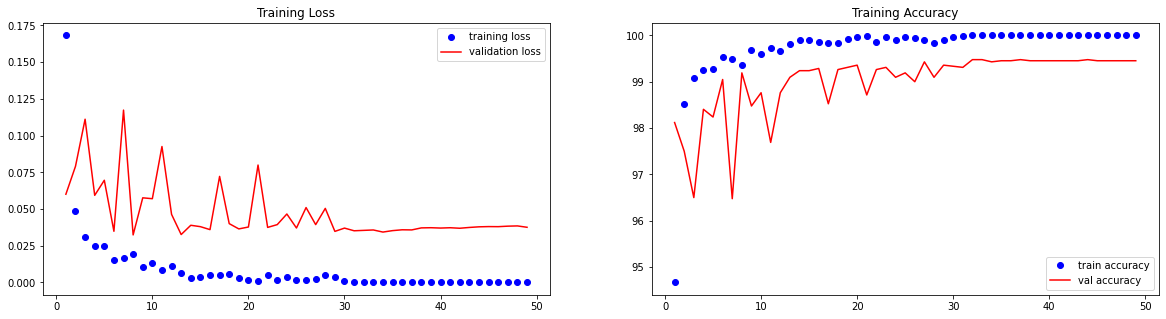

In [253]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Training Accuracy')
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



plt.show()

- 결과를 보면 초반에 loss가 상당히 불안한 것을 확인할 수 있다. 그 이유로는 ResNet18은 kanada-mnist 보다 큰 이미지를 통하여 모델을 구성하여 kanada-mnist에 적용하기에 부적합하며, layer9의 shape을 확인해 보면 (512,1,1)로 Linear한 학습이 되는것이라고 생각할 수 있다. 또한 가중치도 상당히 많기 때문에 overfitting이 발생할 가능성이 크다 따라서 우리 데이터에 맞추어 모델을 조금 수정하여 학습을 진행해보자.

In [ ]:
test_results = []
with torch.no_grad() :
  for data in test_loader :
    data = data.cuda()
    outputs = model(data)
    _, preds = torch.max(outputs.data, 1)
    
    test_results += preds.tolist()

sample_submission['Category'] = test_results

sample_submission.to_csv("submission_cnn_resnet.csv",index=False)

In [318]:
# 위의 층과 다르게 residual block을 7개를 쌓아서 모델을 구성하였다.

class ResNet14(nn.Module):
    def __init__(self):
        super(ResNet14, self).__init__()
        self.in_channels = 64
        self.conv = conv(1, self.in_channels, kernel_size = 7,stride = 2, padding = 3)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride = 2, padding = 1)
        self.layer1 = self.make_layer(ResidualBlock, 64,2)
        self.layer2 = self.make_layer(ResidualBlock, 64,2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, 2)
        self.layer5 = self.make_layer(ResidualBlock, 128, 2)
        self.layer6 = self.make_layer(ResidualBlock, 256, 2, 2)
        self.layer7 = self.make_layer(ResidualBlock, 256,2)
        self.conv2 = conv(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, 10)

    def make_layer(self, block, out_channels, blocks, stride=1):

        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return F.log_softmax(x,dim = 1)

In [319]:
model = ResNet14().cuda()


In [320]:

import torchsummary

torchsummary.summary(model, (1,28,28),verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 14, 14]          3,136
├─BatchNorm2d: 1-2                       [-1, 64, 14, 14]          128
├─ReLU: 1-3                              [-1, 64, 14, 14]          --
├─MaxPool2d: 1-4                         [-1, 64, 7, 7]            --
├─Sequential: 1-5                        [-1, 64, 7, 7]            --
|    └─ResidualBlock: 2-1                [-1, 64, 7, 7]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 7, 7]            36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 7, 7]            128
|    |    └─ReLU: 3-3                    [-1, 64, 7, 7]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 7, 7]            36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 7, 7]            128
|    |    └─ReLU: 3-6                    [-1, 64, 7, 7]            --
|    └─ResidualBlock: 2-2                [-1, 64, 7, 7]            --
|

In [321]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience=3, verbose = True) # scheduler는 학습시 learning rate 수정, early stopping 등 다양한 기능을 지원해준다. 
# 위의 ReduceLROnPlateau는 validation set 에대하여 이전보다 loss가 증가할 경우 기존 learning rate *= 0.8을 해준다. 

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

for epoch in range(1, 50) :
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_loader, phase = 'validation')
  scheduler.step(val_epoch_loss)

  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training 1 Loss : 0.3746 	 Accuracy : 33060/37800     87.46%
validation 1 Loss : 0.2198 	 Accuracy : 3922/4200     93.38%
training 2 Loss : 0.1165 	 Accuracy : 36419/37800     96.35%
validation 2 Loss : 0.2615 	 Accuracy : 3907/4200     93.02%
training 3 Loss : 0.09259 	 Accuracy : 36710/37800     97.12%
validation 3 Loss : 0.1263 	 Accuracy : 4036/4200      96.1%
training 4 Loss : 0.07409 	 Accuracy : 36901/37800     97.62%
validation 4 Loss : 0.07726 	 Accuracy : 4100/4200     97.62%
training 5 Loss : 0.06284 	 Accuracy : 37068/37800     98.06%
validation 5 Loss : 0.08127 	 Accuracy : 4098/4200     97.57%
training 6 Loss : 0.05523 	 Accuracy : 37168/37800     98.33%
validation 6 Loss : 0.05668 	 Accuracy : 4127/4200     98.26%
training 7 Loss : 0.05256 	 Accuracy : 37177/37800     98.35%
validation 7 Loss : 0.06447 	 Accuracy : 4120/4200      98.1%
training 8 Loss : 0.04447 	 Accuracy : 37275/37800     98.61%
validation 8 Loss : 0.07012 	 Accuracy : 4113/4200     97.93%
training 9 Lo

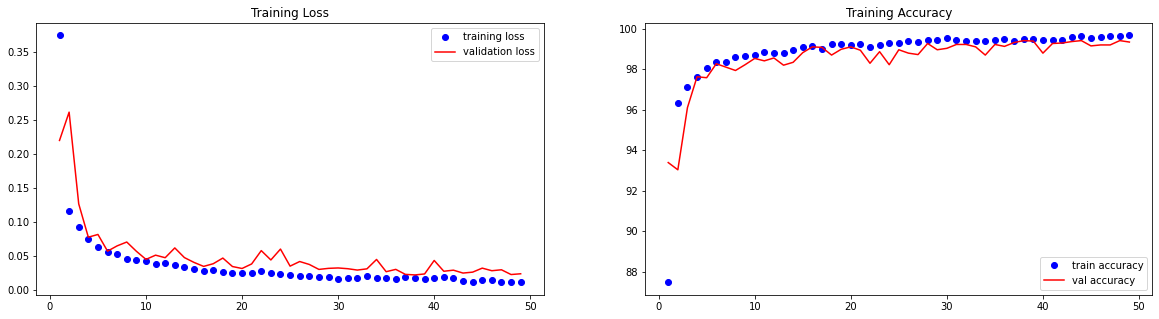

In [322]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Training Accuracy')
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



plt.show()

- 앞의 Resnet18과 비교해 보면 학습이 더욱 안정적으로 된것을 확인할 수 있다. 

In [ ]:
test_results = []
with torch.no_grad() :
  for data in test_loader :
    data = data.cuda()
    outputs = model(data)
    _, preds = torch.max(outputs.data, 1)
    
    test_results += preds.tolist()

sample_submission['Category'] = test_results

sample_submission.to_csv("submission_cnn_resnet_14.csv",index=False)

## CNN - MobileNetV2

- MobileNet의 경우 비교적 최근에 나온 모델 구조인데 이는 Depthwise Separable Convolution 개념을 도입하여 연산량과 모델의 크기를 줄일 수 있었고 성능 또한 다른 모델과 비교하여 뒤쳐지지 않음을 보여주었다.

In [308]:
is_cuda = False
if torch.cuda.is_available() :
  is_cuda = True

# transforms의 RandomHoriziontalFlip과 RandomAffine을 설정해 줌으로서 이미지를 변형 시켜 overfitting이 발생하지 않게끔 하였다.
trans = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomAffine(degrees= 30)])
train_dataset = CustomTensorDataset(data=X_train,label = y_train, transform=trans)
test_dataset = CustomTensorDataset(data=X_test,transform=trans)

valid_size = int(len(X_train)*0.1)
train_size = len(X_train) - valid_size

train_set, valid_set = torch.utils.data.dataset.random_split(train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=512, shuffle= True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size = 128 , shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 256, shuffle= False)

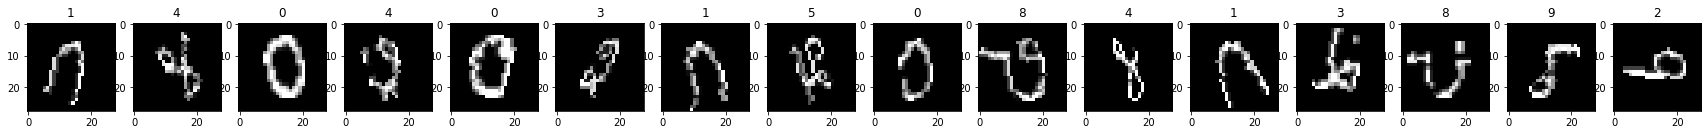

In [309]:
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(int(batch[1][i].data.numpy().tolist()))
        ax[i].imshow(batch[0][i, 0], cmap='gray')
    break

In [310]:
# 모델의 구조는 다음과 같으며 자세한 부분은 https://gaussian37.github.io/dl-concept-mobilenet_v2/ 를 참고하면 된다.

def conv(in_channels, out_channels, kernel_size = 3,stride = 1,padding = 1, groups = 1) :
  return nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size , stride = stride, padding = padding, groups = groups,bias = False)

class dwise_conv(nn.Sequential):
  def __init__(self, in_channels, stride = 1, act=nn.ReLU6(inplace=True)):
    m = [conv(in_channels, in_channels,stride = stride, groups= in_channels), nn.BatchNorm2d(in_channels), act]
    super(dwise_conv, self).__init__(*m)  

class conv1x1(nn.Sequential) :
  def __init__(self, in_channels, out_channels, act =nn.ReLU6(inplace=True)) :
    m = [conv(in_channels, out_channels, kernel_size = 1, padding = 0), nn.BatchNorm2d(out_channels), act]
    super(conv1x1, self).__init__(*m)

class conv3x3(nn.Sequential) :
  def __init__(self, in_channels, out_channels, stride, act = nn.ReLU6(inplace=True)) :
    m = [conv(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)]
    super(conv3x3, self).__init__(*m)

class InvertedBlock(nn.Module) :
  def __init__(self, in_channels, out_channels, expand_ratio, stride) :
    super(InvertedBlock, self).__init__()

    self.stride = stride
    
    hidden_dim = in_channels * expand_ratio

    self.use_res_connect = self.stride == 1 and in_channels == out_channels

    layers = []
    
    if expand_ratio != 1 :
      layers.append(conv1x1(in_channels, hidden_dim))
    layers.extend([
                   dwise_conv(hidden_dim, stride = self.stride),
                   conv1x1(hidden_dim, out_channels)
    ])

    self.layers = nn.Sequential(*layers)

  def forward(self, x) :
    if self.use_res_connect :
      return x + self.layers(x) 
    else :
      return self.layers(x)

class MobileNetV2(nn.Module) :
  
  def __init__(self) :
    super(MobileNetV2, self).__init__()

    self.configs = [
        [1, 16, 1, 1],
        [6, 24, 2, 1],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 2]                  
    ]
    self.stem_conv = conv3x3(1, 32, stride = 2)

    layers = []
    in_channels = 32
    
    for t, c, n, s in self.configs :
      for i in range(n) :
        stride = s if i == 0 else 1
        layers.append(InvertedBlock(in_channels= in_channels, out_channels = c, expand_ratio = t, stride = stride))
        in_channels = c
    
    self.layers = nn.Sequential(*layers)

    self.last_conv = conv1x1(in_channels, 1028)

    self.classifier = nn.Sequential(
        nn.Dropout2d(0.2),
        nn.Linear(1028, 10)
    )
    self.avg_pool = nn.AdaptiveAvgPool2d(1)

    for m in self.modules():   # weight initialization `he normal`
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out')
      elif isinstance(m, (nn.BatchNorm2d)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)

  def forward(self, x) :
    x = self.stem_conv(x)
    x = self.layers(x)
    x = self.last_conv(x)
    x = self.avg_pool(x).reshape(x.shape[0], -1)
    x = self.classifier(x)
    return F.log_softmax(x, dim= 1)


In [311]:
model = MobileNetV2().cuda()

print(model)

MobileNetV2(
  (stem_conv): conv3x3(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (layers): Sequential(
    (0): InvertedBlock(
      (layers): Sequential(
        (0): dwise_conv(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): conv1x1(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedBlock(
      (layers): Sequential(
        (0): conv1x1(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=

In [312]:
torchsummary.summary(model, (1,28,28), verbose = 0)

Layer (type:depth-idx)                   Output Shape              Param #
├─conv3x3: 1-1                           [-1, 32, 14, 14]          --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          288
├─Sequential: 1-2                        [-1, 320, 1, 1]           --
|    └─InvertedBlock: 2-2                [-1, 16, 14, 14]          --
|    |    └─Sequential: 3-1              [-1, 16, 14, 14]          896
├─conv1x1: 1                             []                        --
|    └─ReLU6: 2-3                        [-1, 16, 14, 14]          --
├─Sequential: 1                          []                        --
|    └─InvertedBlock: 2-4                [-1, 24, 14, 14]          --
|    |    └─Sequential: 3-2              [-1, 24, 14, 14]          5,136
├─conv1x1: 1                             []                        --
|    └─ReLU6: 2-5                        [-1, 96, 14, 14]          --
|    └─ReLU6: 2-6                        [-1, 24, 14, 14]          --
├─Sequenti

In [313]:
optimizer = optim.Adam(model.parameters(),lr=0.001, weight_decay= 1e-5) # weight_decay는 L2 norm을 이용하여 규제를 주는 방법이다.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.7, patience=4, verbose = True)

train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []

for epoch in range(1, 100) :
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_loader, phase = 'validation')
  scheduler.step(val_epoch_loss)

  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training 1 Loss : 2.165 	 Accuracy : 7311/37800     19.34%
validation 1 Loss : 2.431 	 Accuracy : 500/4200      11.9%
training 2 Loss : 1.423 	 Accuracy : 18333/37800      48.5%
validation 2 Loss : 0.9745 	 Accuracy : 2729/4200     64.98%
training 3 Loss : 0.7378 	 Accuracy : 28024/37800     74.14%
validation 3 Loss : 0.5489 	 Accuracy : 3399/4200     80.93%
training 4 Loss : 0.4618 	 Accuracy : 31976/37800     84.59%
validation 4 Loss : 0.3885 	 Accuracy : 3669/4200     87.36%
training 5 Loss : 0.3256 	 Accuracy : 33752/37800     89.29%
validation 5 Loss : 0.247 	 Accuracy : 3834/4200     91.29%
training 6 Loss : 0.2519 	 Accuracy : 34706/37800     91.81%
validation 6 Loss : 0.2441 	 Accuracy : 3881/4200      92.4%
training 7 Loss : 0.2116 	 Accuracy : 35165/37800     93.03%
validation 7 Loss :  0.19 	 Accuracy : 3916/4200     93.24%
training 8 Loss : 0.1791 	 Accuracy : 35624/37800     94.24%
validation 8 Loss : 0.1579 	 Accuracy : 3986/4200      94.9%
training 9 Loss : 0.1639 	 Accu

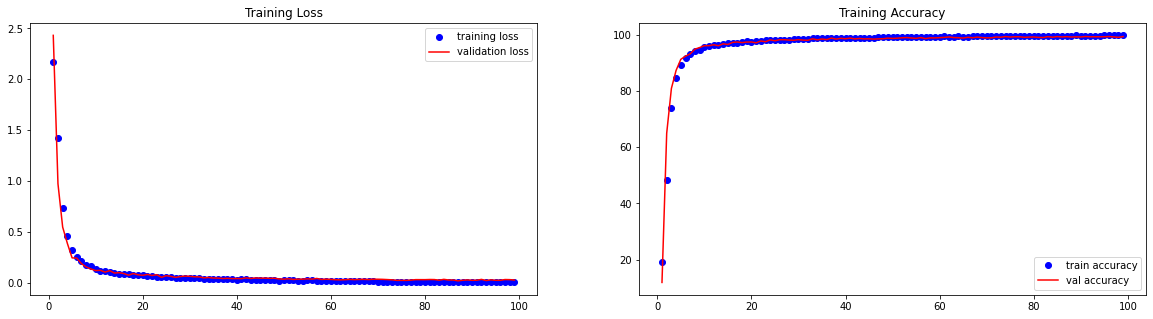

In [314]:
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

plt.subplot(1,2,2)

plt.title('Training Accuracy')
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



plt.show()

In [315]:
test_results = []
with torch.no_grad() :
  for data in test_loader :
    data = data.cuda()
    outputs = model(data)
    _, preds = torch.max(outputs.data, 1)
    
    test_results += preds.tolist()

sample_submission['Category'] = test_results

sample_submission.to_csv(f"submission_cnn_{model.__class__.__name__}.csv",index=False)

### Result


|Model|Parameters|ACC|
|------|--------|---|
|DNN|242,762|98.32%|
|DNN+BatchNorm|243,658|98.56%|
|CNN|21,840|99.21%|
|Vgg11|15,430,338|99.46%|
|ResNet18|25,241,034|99.52%|
|**ResNet14**|**7,538,122**|**99.58%**|
|MobileNetV2|2,152,378|99.3%|

* 결과를 확인해 보면 위의 표와 같다. 우선 DNN을 모델로 사용했을 경우 BatchNorm을 추가 하였을 때 전보다 0.2%의 성능 향상을 보여주었다.
* 간단한 CNN의 모델을 보면 DNN과 비교하여 월등히 적은 Parameter를 보여주지만 성능은 1% 정도 상승한 것을 확인할 수 있다. 
* 또한 기존에 구현했던 VGG11, ResNet18의 경우 상당한 Parameter 수를 가지고 있고 성능 또한 CNN에 비해 0.2~ 0.3% 정도 상승하였다. 
* ResNet14 의 경우 데이터의 형태에 맞추어 경량화를 시도하였고, 기존 ResNet18의 Parameter 수의 1/3 만으로 0.06% 성능이 올랐다.
* MobileNetV2 경우 다른 모델들과 비교하여 확연하게 적은 Parameter 수를 가지고 있지만 성능은 그에 미치지 못하는 모습을 보였다. 아마 데이터에 맞추어 경량화를 좀더 했으면 좋은 성능이 나오지 않을까 생각을 한다.